# Tutorial for basic usage of pystablemotifs 

This is a simple tutorial to demonstrate the basic functionalities of the pystablemotif code. This includes:
* Reading in a Boolean model
* Generating the _attractor repertoire_ of the model with basic export tools
* Generating and plotting the _succession diagrams_ with basic plotting and export functions
* Using stable motif control methods


In [1]:
import pystablemotifs as sm
import pyboolnet
import pystablemotifs.export as ex
import networkx as nx

## Read in a Boolean model:

In [2]:
rules='''xA*=xB
xB*=xA
xC*=xA or not xD
xD*=xC
xE*=xB and xF
xF*=xE'''

We reprint the rules to verify they were properly imported.

In [3]:
primes = sm.format.create_primes(rules)
sm.format.pretty_print_prime_rules(primes)

xA* = xB
xB* = xA
xC* = !xD | xA
xD* = xC
xE* = xB & xF
xF* = xE


It is also possible to import Boolean rules from a plaintext file.

In [4]:
sm.format.pretty_print_prime_rules(
    sm.format.import_primes('simple_model.txt'))

xA* = xB
xB* = xA
xC* = !xD | xA
xD* = xC
xE* = xB & xF
xF* = xE


## Generating the Attractor repertoire

The parameter `max_simulate_size` controls how many nodes we are willing to simulate in a network. Decreasing this number will produce faster results, but we may be left with "candidate" attractors that may or may not correspond to true attractors. The default value is `20`.

In [5]:
max_simulate_size=20

The `AttractorRepertoire` class contains information about the attractors of the system. It is generated using the `from_primes` function.

In [6]:
ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)

### What do we know about the attractors?

In [7]:
ar.summary()

There are 3 attractors.
{'xA': 1, 'xB': 1, 'xC': 1, 'xD': 1, 'xE': 0, 'xF': 0}

{'xA': 0, 'xB': 0, 'xC': 'X', 'xD': 'X', 'xE': 0, 'xF': 0}

{'xA': 1, 'xB': 1, 'xC': 1, 'xD': 1, 'xE': 1, 'xF': 1}



If we want the attractors in a DataFrame:

In [8]:
df=ex.attractor_dataframe(ar)
df

,xA,xB,xC,xD,xE,xF
0,1,1,1,1,0,0
1,0,0,X,X,0,0
2,1,1,1,1,1,1


To access the attractors as dictionaries:

In [9]:
for a in ar.attractors:
    print(a.attractor_dict)

{'xA': 1, 'xB': 1, 'xC': 1, 'xD': 1, 'xE': 0, 'xF': 0}
{'xA': 0, 'xB': 0, 'xC': 'X', 'xD': 'X', 'xE': 0, 'xF': 0}
{'xA': 1, 'xB': 1, 'xC': 1, 'xD': 1, 'xE': 1, 'xF': 1}


We can access the state transition graph (STG) of a complex (oscillatory) attractor as follows:

{'xA': 0, 'xB': 0, 'xC': 'X', 'xD': 'X', 'xE': 0, 'xF': 0}


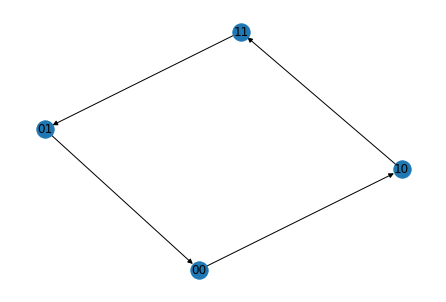

In [10]:
for a in ar.attractors:
    if a.n_unfixed == 0: continue # skip steady states
    print(a.attractor_dict)
    nx.draw(a.stg,with_labels=True)

The labels are correspond to the values of free nodes in alphabetical order. For example, in the above plot, `01` corresponds to the state `xC=0, xD=1`. Other variable values are fixed according to the attractor dictionary, i.e., `xA=xB=xE=xF=0`, in this example. 

## Generating and plotting the Succession Diagrams

### Reduced-network-based succession diagram
In this representation, nodes correspond to the networks obtained by plugging in stable motifs and percolating values.

In [11]:
GR=ex.networkx_succession_diagram(ar,include_attractors_in_diagram=True)

We can plot the succession diagram using matplotlib and networkx. Various plotting parameters can be adjusted. Please consult the function docstring for more information (by pressing Shift+Tab when the cursor is in the function or by running `ex.networkx_succession_diagram?`)



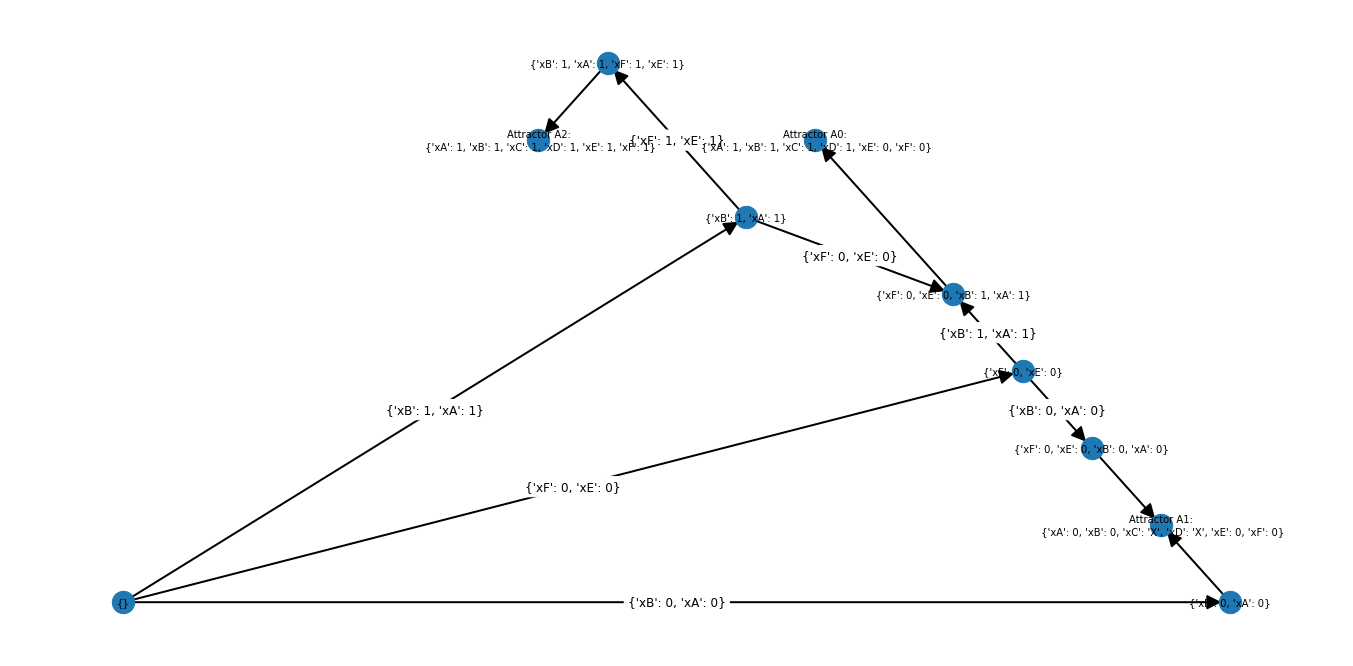

In [12]:
ex.plot_nx_succession_diagram(GR,draw_edge_labels=True,
                              nx_node_label_kwargs={'font_size':10},
                              nx_edge_label_kwargs={'font_size':12,'rotate':False})

### Motif-based succession diagram
Notice that the nodes of the motif-based succession diagram correspond ot the edges of the reduced-network-based succession diagram.

In [13]:
GM=ex.networkx_succession_diagram_motif_based(ar,include_attractors_in_diagram=True)

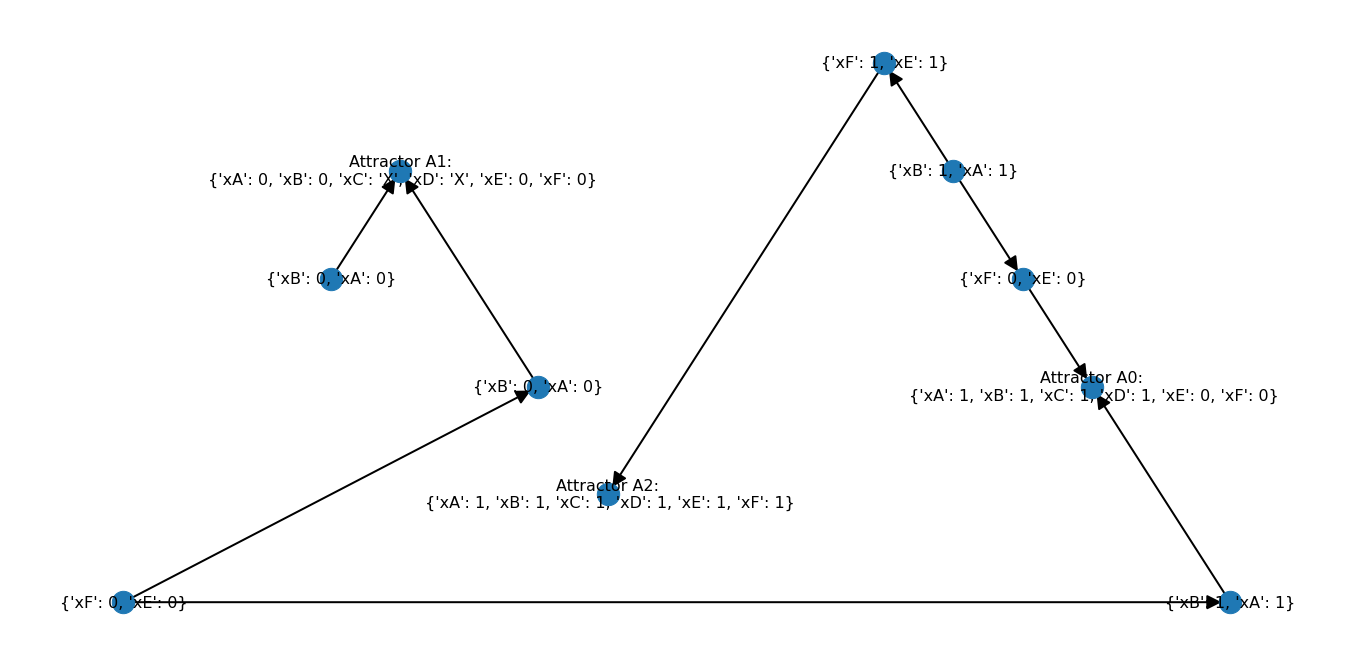

In [14]:
ex.plot_nx_succession_diagram(GM)

In case we only need the set of unique stable motifs:

In [15]:
ar.succession_diagram.get_motifs()

[{'xA': 1, 'xB': 1},
 {'xE': 1, 'xF': 1},
 {'xE': 0, 'xF': 0},
 {'xA': 0, 'xB': 0}]

### Plotting with yED

Plotting the succession diagrams in matplolib is an quick and efficient way of having a glimpse at the succession diagram, however in the case of large and more complex diagrams this can become inefficient. We suggest exporting the diagrams and plotting them with tools such as yED. Here we explain how to do it:
* First, we export the succession diagram into graphml format. The attributes such as the label are preserved by the format.

In [16]:
ex.save_to_graphml(GR,model_name='succ_diagram_example')

* Next, open the saved graphml in yED.
* Go to Edit -> Properties Mapper.
* (optional) In the top left corner of the pop-up window click *import additional configuration* and select the *succession_diagram_and_expanded_network_yED_property_maps.cnfx* config file from GitHub. 
* Set up the configuration and click *Apply*.
* Finally, we suggest a hierarchical layout. To get this go to Layout -> Hierarchical.

## Controlling Attractors

There are several different algorithms and heuristics that can help determine what is the minimum set of nonredundant nodes that need to be fixed in order to make the system reach a desired state _from any other state_. The target state can be a subset of the nodes as well.

The _reprogram_trap_spaces()_ function handles all the implemented control methods. Its inputs are the target node states and the method combinations. Here we give and example for the default _history + internal_ method. Please consult the documentation and/or the control tutorial for the other methods.  

_history + internal_ :
Finds all shortest stable motif histories that result in the target node states being logically fixed. Each stable motif is searched for internal driver nodes. The resulting internal drivers are combined into a single  control set. The returned list consists of all such control sets for all stable motif histories. Each control set eventually becomes self-sustaining.



In [17]:
target_state={'xA': 1, 'xB': 1, 'xC': 1, 'xD': 1, 'xE': 1, 'xF': 1}
ar.succession_diagram.reprogram_to_trap_spaces(logically_fixed=target_state,
                                               target_method='history',
                                               driver_method='internal')

[{'xB': 1, 'xF': 1},
 {'xB': 1, 'xE': 1},
 {'xA': 1, 'xF': 1},
 {'xA': 1, 'xE': 1}]

Please consult the function docstring for more information (by pressing Shift+Tab when the cursor is in the function or by running `ar.succession_diagram.reprogram_to_trap_spaces?`)
